In [1]:
!/opt/bin/nvidia-smi
!nvcc --version

/bin/sh: 1: /opt/bin/nvidia-smi: not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [23]:
!curl -s https://course.fast.ai/setup/colab | bash

mkdir: cannot create directory ‘/root’: Permission denied
mkdir: cannot create directory ‘/root’: Permission denied
ln: failed to create symbolic link '/content': Permission denied
ln: failed to create symbolic link '/content': Permission denied
Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

In [5]:
!wget 'https://storage.googleapis.com/sherlock_datasets/CASIA_ELA.zip.7z'

--2020-04-06 14:32:03--  https://storage.googleapis.com/sherlock_datasets/CASIA_ELA.zip.7z
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1375594296 (1.3G) [application/x-7z-compressed]
Saving to: ‘CASIA_ELA.zip.7z’

CASIA_ELA.zip.7z    100%[===================>]   1.28G  10.7MB/s    in 74s     

2020-04-06 14:33:18 (17.8 MB/s) - ‘CASIA_ELA.zip.7z’ saved [1375594296/1375594296]



In [11]:
!7z e CASIA_ELA.zip.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1375594296 bytes (1312 MiB)

Extracting archive: CASIA_ELA.zip.7z
--
Path = CASIA_ELA.zip.7z
Type = 7z
Physical Size = 1375594296
Headers Size = 130
Method = LZMA2:26
Solid = -
Blocks = 1

  0%      3% - CASIA_ELA.zip                      7% - CASIA_ELA.zip                     11% - CASIA_ELA.zip                     15% - CASIA_ELA.zip                     20% - CASIA_ELA.zip                     30% - CASIA_ELA.zip                     39% - CASIA_ELA.zip

In [0]:
!unzip -o -q CASIA_ELA.zip

In [0]:
def exportStageTo(learn, path):
    learn.export()
    copyfile(path/'export.pkl', path/'export-ela.pkl')

def restoreStageFrom(path):
    # Restore a backup
    copyfile(path/'export-ela.pkl', path/'export.pkl')
    return load_learner(path)

In [27]:
path = Path("/home/tiago4k_gmail_com/CASIA_ELA"); path

PosixPath('/home/tiago4k_gmail_com/CASIA_ELA')

In [0]:
path_to_test = Path("/home/tiago4k_gmail_com/CASIA_ELA/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

In [0]:
# Batch Size
bs = 28
# Image size, 448x448
size = 448
data = ImageDataBunch.from_folder(path, train='Train', valid='Valid', 
                                  ds_tfms = tfms, size=size, bs=bs)

# data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

In [0]:
print('Transforms = ', len(tfms))
print(data.classes)
data

In [36]:
data.show_batch(rows=5, figsize=(15,15))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

In [0]:
# learn.destroy

In [40]:
learn.fit_one_cycle(10)
learn.save('ela-stage-1')
# exportStageTo(learn, path)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.392505,0.330539,0.909440,0.090560,01:28
1,0.274322,0.207714,0.917367,0.082633,01:23
2,0.234478,0.171187,0.926976,0.073024,01:21
3,0.199689,0.181040,0.927696,0.072304,01:21
4,0.156422,0.176774,0.937065,0.062935,01:22
5,0.162517,0.166545,0.920730,0.079270,01:22
6,0.154106,0.130873,0.944751,0.055249,01:21
7,0.121352,0.117843,0.951717,0.048282,01:22
8,0.144246,0.118543,0.951717,0.048282,01:21
9,0.133676,0.116700,0.951717,0.048282,01:22


In [41]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

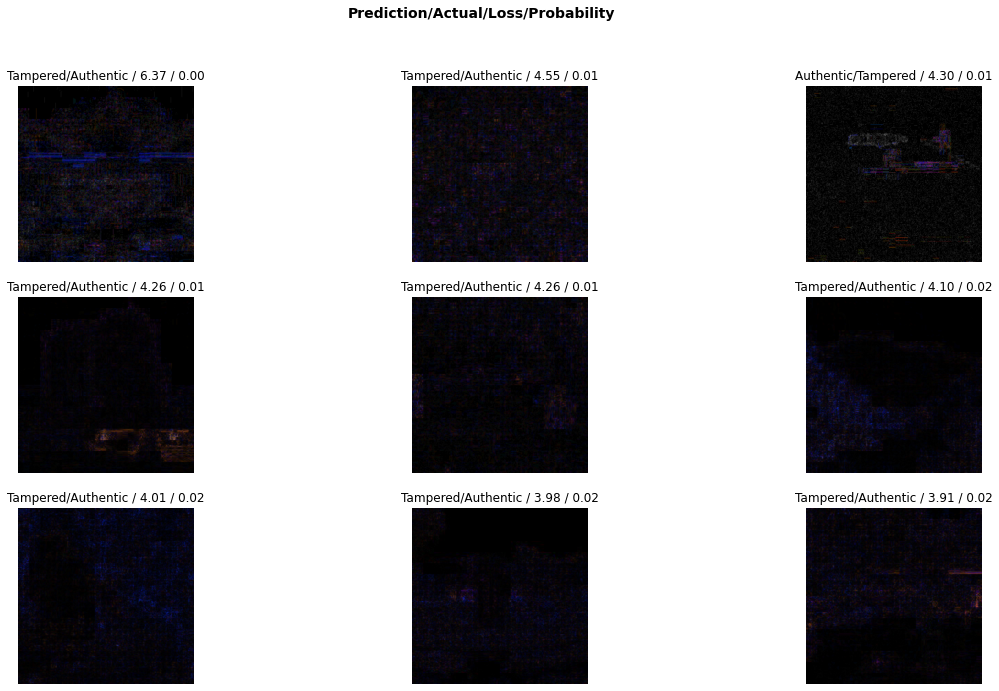

In [0]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

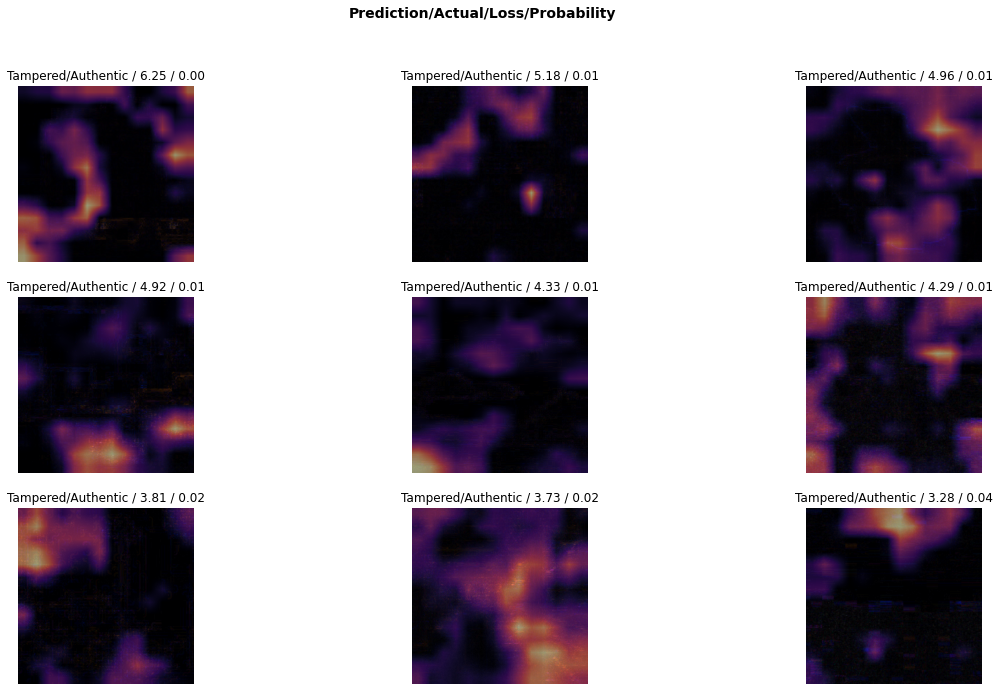

In [42]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

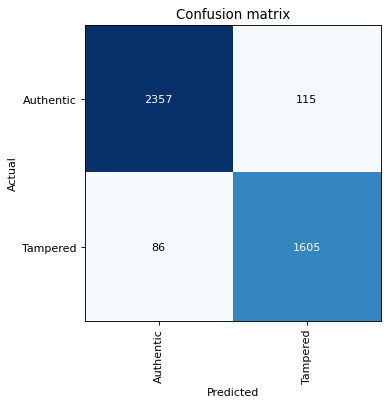

In [43]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

In [44]:
losses

tensor([6.2495, 5.1781, 4.9565,  ..., -0.0000, -0.0000, -0.0000])

In [45]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


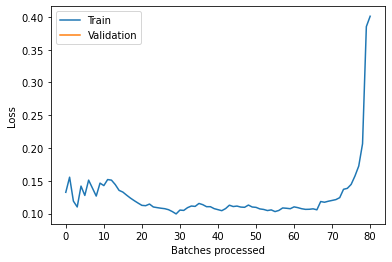

In [46]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


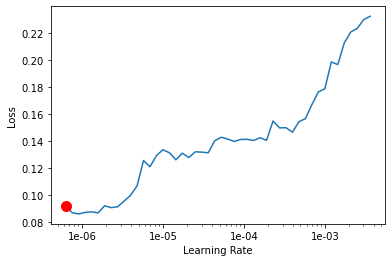

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.load('/home/tiago4k_gmail_com/CASIA_ELA/models/ela-stage-1')

In [54]:
learn.unfreeze()

learn.fit_one_cycle(30, max_lr=slice(1e-5,1e-6), 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='ela')])

learn.save('ela-stage-2')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.115601,0.117379,0.951958,0.048042,01:44
1,0.124989,0.116955,0.953639,0.046361,01:44
2,0.111654,0.115193,0.953159,0.046841,01:44
3,0.123430,0.117165,0.952438,0.047562,01:44
4,0.131852,0.114579,0.955080,0.044920,01:44
5,0.108855,0.115240,0.952678,0.047322,01:44
6,0.113905,0.109530,0.957242,0.042758,01:44
7,0.110210,0.107523,0.957483,0.042517,01:44
8,0.106840,0.116393,0.953399,0.046601,01:44
9,0.108625,0.110313,0.955801,0.044199,01:44


In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

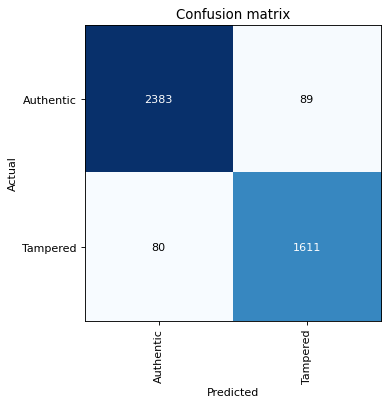

In [56]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

Get Predictions and accuracy on the test dataset

In [0]:
learn.export()

In [0]:
learn = load_learner(path)

In [58]:
path = '/home/tiago4k_gmail_com/CASIA_ELA/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            # if conf >=65:
            #     print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

/home/tiago4k_gmail_com/CASIA_ELA/Test/Tampered/
/home/tiago4k_gmail_com/CASIA_ELA/Test/Authentic/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [60]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
476/502. Accuracy = 94.82%
Images Classified As Tampered
323/344. Accuracy = 93.90%


In [61]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 96.188%


Predict on a single image

In [0]:
img = open_image('/content/data/CASIA_ELA/Test/Tampered/Tp_D_CRN_M_B_ani00019_nat00013_11868.ela.png')

In [0]:
pred_class,pred_idx,confidence = learn.predict(img); pred_class

Category Tampered

Create a heatmap of the image

In [0]:
!pip install Pillow --upgrade

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (7.0.0)


In [0]:
!pip install fastai2

In [0]:
from fastai.callbacks.hooks import *
from fastai2.vision.all import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
fn = Path("/root/.fastai/data/CASIA_ELA/Test/Tampered/Tp_D_CRN_M_B_ani00019_nat00013_11868.ela.png")

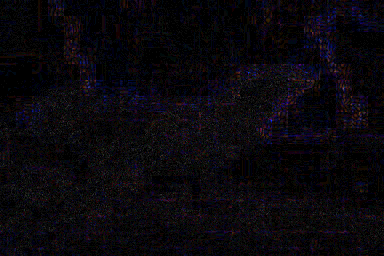

In [0]:
x = PILImage.create(fn); x